  $G_i + P \quad[k^{b_P}_i]<->[k^{u_P}_i] \quad  G_i:P \\
    G_i:P \quad  --> [k_i^{tx}] \quad  G_i + P + T_i \\
    T_i + R \quad  [k^{b_R}_i]<->[k^{u_R}_i]\quad   T_i:R \\
    T_i:R  \quad -->[k_i^{tl}]\quad T_i + R + X_i \\
    T_i + E \quad  [k^{b_E}_i]<->[k^{u_E}_i] \quad  T_i:E \\
    T_i:E \quad-->[\delta_i]\quad E \\
    X \quad-->[d]\quad $

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from auto_reduce import *
import numpy as np
from sympy import symbols

In [2]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 8 # Number of states : P, C1, T, R, C2, E, C3, X
nouts = 1 # Number of outputs, X_i

# Inputs by user 
x_init = np.zeros(n)
x_init[0] = 10000
x_init[3] = 10000
x_init[5] = 10000
C = np.zeros((nouts,n), dtype=int)
C[0][7] = 1

nstates_tol_max = 4
error_tol = 3000
# System dynamics symbolically

# k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d = params, len(params) = 10


x0 = symbols('P')
x1 = symbols('C1') # G:P
x2 = symbols('T')
x3 = symbols('R')
x4 = symbols('C2') # T:R
x5 = symbols('E')
x6 = symbols('C3') # T:E
x7 = symbols('X')

x = [x0, x1, x2, x3, x4, x5, x6, x7]

G = symbols('G')
k_bp = symbols('k_bp')
k_up = symbols('k_up')
k_tx = symbols('k_tx')
k_br = symbols('k_br')
k_ur = symbols('k_ur')
k_tl = symbols('k_tl')
k_be = symbols('k_be')
k_ue = symbols('k_ue')
d_i = symbols('d_i')
d = symbols('d')

E_tot = symbols('E_tot')
P_tot = symbols('P_tot')
R_tot = symbols('R_tot')
params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot, G]
# f0 = (k_bp + k_tx) * x1 - k_up * G * x0
f0 = (k_bp + k_tx) * x1 - k_up * G * x0
f1 = k_bp * G * x0 - (k_up + k_tx)*x1
f2 = k_tx * x1 + k_ur * x4 - k_br * x2 * x3
f3 = (k_ur + k_tl) * x4 - k_br * x2 * x3
f4 = k_br * x2 * x3 - (k_ur + k_tl) * x4
f5 = (k_ue + d_i) * x6 - k_be * x3 * x5
f6 = k_be * x2 * x5 - (k_ue + d_i) * x6
f7 = k_tl * x4 - d * x7
    
f = [f0,f1,f2,f3,f4,f5,f6,f7]
# parameter values
params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 1, 1000, 1000, 1000, 10]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

C:\Users\apand\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


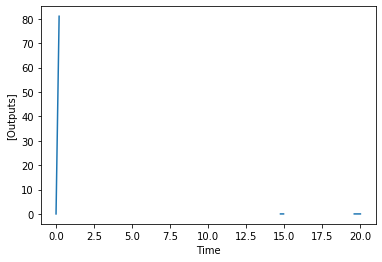

In [5]:
from auto_reduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
plt.xlabel('Time')
plt.ylabel('[Outputs]')
plt.show()

In [3]:
from auto_reduce.utils import get_SSM
timepoints_ssm = np.linspace(0,100,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
Ss = sys_ssm.compute_SSM(mode = 'accurate') # len(timepoints) x len(params) x len(states)
out_Ss = []
for i in range(len(params)):
    out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

C:\Users\apand\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\apand\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\apand\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\apand\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [4]:
J1 = sys_ssm.compute_J([10,1000,5,10000,100,10000,5,10], mode = 'accurate')
import scipy
scipy.linalg.eigvals(J1)
np.shape(J1)

array([-1.00000000e+00+0.j, -1.00050251e+05+0.j, -1.00000001e+05+0.j,
       -3.82344433e+02+0.j,  2.68344433e+02+0.j, -1.99899549e+00+0.j,
       -1.49924999e+00+0.j,  7.71403448e-09+0.j])

(8, 8)

Text(0.5, 15.0, 'Time')

Text(33.0, 0.5, 'Parameters')

Text(0.5, 1, 'Sensitivity of output[0] with respect to all parameters')

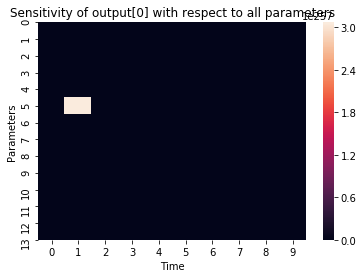

In [5]:
import seaborn as sn
import matplotlib.pyplot as plt
for j in range(nouts):
    sn.heatmap(out_Ss[:,:,j].T)
    plt.xlabel('Time')
    plt.ylabel('Parameters')
    plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    plt.show()

In [6]:
from auto_reduce.utils import reduce
timepoints_ssm = np.linspace(0,2,10)
timepoints_ode = np.linspace(0,2,100)
sys_reduce = reduce(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol = 4

In [7]:
P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [C1, C2, C3]
f_cons = sys_reduce.set_conservation_laws(conserved_quantities, states_to_eliminate)

Text(0.5, 0, 'Time')

Text(0, 0.5, '[X]')

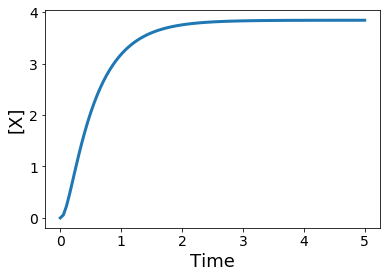

In [38]:
from auto_reduce.utils import get_ODE
timepoints_ode = np.linspace(0, 5, 100)
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot, G]
params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 10000, 10000, 10000, 0.01]
sys_reduce.params_values = params_values
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), linewidth = 3)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.legend()
plt.show()

In [42]:
# results = sys_reduce.reduce_simple()
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T, X])
sys_reduce.get_robustness_metric(reduced_sys)
sys_reduce.get_error_metric(reduced_sys)


attempting to retain : [1, 4]
Successful time-scale separation solution obtained.
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Robustness Metric Progress: |██████████████████████████████████████████████████| 100.0% Complete


array([2.00000048e-01, 2.00000000e-01, 2.00567408e-01, 2.97270495e+05,
       4.19891139e+01, 7.86949666e+00, 2.00000000e-01, 2.00232052e-01,
       2.00430438e-01, 8.05023162e+06, 2.00000066e-01, 2.00000246e-01,
       4.26525200e+03, 2.00036806e-01])

12.572144073511055

In [ ]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([1,3,5])
reduced_sys.f[1]
# from auto_reduce.utils import get_ODE
x_sol_hat = get_ODE(sys_reduce.get_system(), timepoints_ode).solve_system()

In [ ]:
# results
import matplotlib.pyplot as plt
for key, value in results.items():
    plt.scatter(value[0], key.n,linewidths = 2.5, label = str(key.x))
plt.legend()
plt.savefig('enzymatic_rxn_e.svg')

In [ ]:
def get_linearized_models(system_obj, output):
    

In [47]:
reduced_sys.f[1]

IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
y_hat = sys_reduce.C@x_sol_hat.T
plt.plot(timepoints_ode,y_hat.T)

In [21]:
from auto_reduce.utils import reduce_utils
rx = reduce_utils(sys_reduce)
rx.write_results('gene_expression_results2.txt')

In [20]:
results

{<auto_reduce.system.System at 0x23cd588dd08>: [1820.9105557960245,
  array([5.93329261e+48, 1.31286936e+37, 2.26146038e+34, 5.64156201e+24,
         6.20776566e+25, 1.24603961e+36, 1.91854215e+35, 1.62534793e+22,
         5.63549796e+25, 1.55192822e+24, 4.09077900e+22, 1.91854215e+33,
         9.09756304e-16])],
 <auto_reduce.system.System at 0x23cd3f03e48>: [2070.5658094205155,
  array([6.29248033e+178, 7.90348418e+005, 7.67916723e+005, 1.00001189e-001,
         5.78422384e-001, 4.56193861e+004, 1.00000382e-001, 8.44120580e-001,
         1.57639264e+146, 1.64011959e+011, 1.66050295e+157, 1.10794845e+154,
         9.15012147e-001])],
 <auto_reduce.system.System at 0x23cd584dac8>: [1820.9105557960245,
  array([2.13909132e+17, 7.90348318e+05, 7.67916623e+05, 8.18127956e-07,
         6.31350113e-01, 6.68146918e-07, 7.76434510e-11, 7.67134225e-03,
         5.81646804e+05, 2.43307563e+09, 2.23710309e+01, 1.18066590e-05,
         8.40218315e-03])],
 <auto_reduce.system.System at 0x23cd55654

In [24]:
sys_reduce.g

In [26]:
from sympy.printing import latex
filename = 'test_gene_expr.txt'
f1 = open(filename, 'w')
f1.write('Model reduction results.\n')
for key,value in sys_reduce.results_dict.items():
    f1.write('A possible reduced model: \n \n')
    f1.write('\n$x_{hat} = ')
    f1.write(str(key.x))
    f1.write('$\n\n\n\n')
    for k in range(len(key.f)):
        f1.write('\n$f_{hat}('+ str(k+1) + ') = ')
        f1.write(latex(key.f[k]))
        f1.write('$\n\n')
    f1.write('\n\n\n')
    f1.write('\nError metric:')
    f1.write(str(value[0]))
    f1.write('\n\n\n')
    f1.write('\nRobustness metric:')
    f1.write(str(value[1]))
    f1.write('\n\n\n')
    f1.write('Other properties') 
    f1.write('\n\n\n')
    f1.write('\n C = ')
    f1.write(str(key.C))
    f1.write('\n$ g = ')
    f1.write(str(key.g))
    f1.write('$\n h = ')
    f1.write(str(key.h))
    f1.write('\n$h = ')
    f1.write(str(key.h))
    f1.write('$\n Solutions : \n')
    f1.write(str(key.x_sol))
    f1.write('\n\n\n\n')
    f1.write('\n Sensitivity Solutions : \n')
    f1.write(str(key.S))
    f1.write('\n\n\n\n')
f1.close()

In [49]:
# G,T,X
# G,C1,T,X
# G,C2,T,X
# G,C3,T,X
x_gtx = list(results.keys())[7].x_sol
sys_gtx = list(results.keys())[7]
x_gc1tx = list(results.keys())[16].x_sol
sys_gc1tx = list(results.keys())[16]
x_gc2tx = list(results.keys())[19].x_sol
sys_gc2tx = list(results.keys())[19]
x_gc3tx = list(results.keys())[20].x_sol
sys_gc3tx = list(results.keys())[20]



In [132]:
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot]

params_values_new = params_values = [100, 10, 4, 10, 0.25, 2, 1, 0.5, 1, 10, 1000, 1000, 1000]
sys.params_values = params_values_new
sys_gtx.params_values = params_values_new
sys_gc1tx.params_values = params_values_new
sys_gc2tx.params_values = params_values_new
sys_gc3tx.params_values = params_values_new
timepoints_ode = np.linspace(0, 2, 100)

sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T


sys_gtx_ode = get_ODE(sys_gtx, timepoints_ode)
x_gtx = sys_gtx_ode.solve_system().T


sys_gc1tx_ode = get_ODE(sys_gc1tx, timepoints_ode)
x_gc1tx = sys_gc1tx_ode.solve_system().T


sys_gc2tx_ode = get_ODE(sys_gc2tx, timepoints_ode)
x_gc2tx = sys_gc2tx_ode.solve_system().T


sys_gc3tx_ode = get_ODE(sys_gc3tx, timepoints_ode)
x_gc3tx = sys_gc3tx_ode.solve_system().T


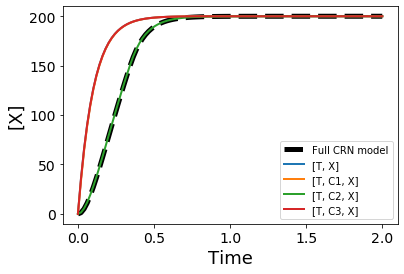

In [149]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
plt.plot(timepoints_ode, np.transpose(np.array(sys_gtx.C)@x_gtx), label = '[T, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(np.array(sys_gc1tx.C)@x_gc1tx), label = '[T, C1, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(np.array(sys_gc2tx.C)@x_gc2tx), label = '[T, C2, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(np.array(sys_gc3tx.C)@x_gc3tx), label = '[T, C3, X]', linewidth = 2)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.savefig('gene_expression_timecourse.svg')
plt.show()

In [160]:
g0 = - k_up * x1
g1 = - k_up * x1
g2 = k_bp * x1 
g3 = 0
g4 = 0
g5 = 0
g6 = 0
g7 = 0
g8 = 0
g = [g0,g1,g2,g3,g4,g5,g6,g7,g8]


G*P_tot*k_bp*(k_bp + k_tx)/(G*k_bp + k_tx + k_up) - G*k_up*(-G*P_tot*k_bp/(G*k_bp + k_tx + k_up) + P_tot)

In [181]:
def evaluate(system, f, x, P, u = None):
    """
    Evaluate the given symbolic function (f) that is part of the System
    at the values given by x for self.x and P for self.params
    """
    fs = []
    for i in range(len(f)):
        fi = f[i]
        fi = fi.subs(list(zip(system.x, x)))
        if system.u is not None:
            fi = fi.subs(list(zip(system.u, u)))
        fi = fi.subs(list(zip(system.params, P)))
        fs.append(fi)
    return fs

def compute_J(system, x, **kwargs):
    '''
    Compute the Jacobian J = df/dx at a timepoint k.
    Returns a matrix of size n x n.
    Use mode = 'accurate' for this object attribute to use accurate computations using numdifftools.
    '''
    
    # initialize J
    J = np.zeros( (system.n, system.n) )   
    P = system.params_values 
    u = system.u
    # store x
    X = x 
    if 'fun' in kwargs:
        fun = kwargs.get('fun')
    else:
        fun = system.f
    for i in range(system.n):
        for j in range(system.n):
            F = np.zeros( (4,1) )
            h = X[j]*0.01
            # Gets O(4) central difference on dfi/dxj
            if h != 0:
                x = X
                x[j] = X[j] + 2*h
                f = evaluate(system, fun, x, P, u)
                F[0] = f[i]
                x[j] = X[j] + h
                f = evaluate(system, fun, x, P, u)
                F[1] = f[i]
                x[j] = X[j] - h
                f = evaluate(system, fun, x, P, u)
                F[2] = f[i]
                x[j] = X[j] - 2*h
                f = evaluate(system, fun, x, P, u)
                F[3] = f[i]
                #Store approx. dfi/dxj into J
                J[i,j]= (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h)   
                # print(J[i,j])
                # if J[i,j] == np.Inf:
                #     J[i,j] = 1
                # elif J[i,j] == np.NaN:
                #     J[i,j] = 0
    return J


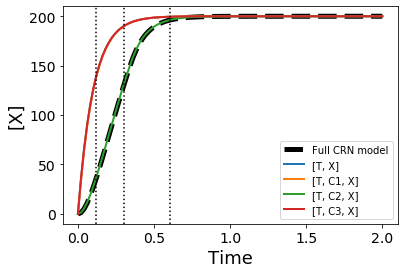

In [273]:
t_lin = [timepoints_ode[6], timepoints_ode[15], timepoints_ode[30]]
# t_lin = [timepoints_ode[6]]
fig, ax = plt.subplots()
out_sol = np.array(sys_reduce.C)@sol
out_gtx = np.array(sys_gtx.C)@x_gtx
out_gc1tx = np.array(sys_gc1tx.C)@x_gc1tx
out_gc2tx = np.array(sys_gc2tx.C)@x_gc2tx
out_gc3tx = np.array(sys_gc3tx.C)@x_gc3tx
plt.plot(timepoints_ode, np.transpose(out_sol), 'k--', label = 'Full CRN model', linewidth = 5)
plt.plot(timepoints_ode, np.transpose(out_gtx), label = '[T, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc1tx), label = '[T, C1, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc2tx), label = '[T, C2, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc3tx), label = '[T, C3, X]', linewidth = 2)

for t in t_lin:
    x_pt = sol[:,list(timepoints_ode).index(t)]
    J_full = compute_J(sys_reduce, x_pt)
#     B_full = compute_J(sys_reduce, x_pt, var = sys_reduce.g)
    n_size = np.shape(J_full)[1]
    A_full = J_full[1:n_size,1:n_size]
    B_full = J_full[0,:]
    C_full = sys_reduce.C
#     G_full = 
    
    x_pt = x_gtx[:,list(timepoints_ode).index(t)]
    J_gtx = compute_J(sys_gtx, x_pt)
    n_size = np.shape(J_gtx)[1]
    A_gtx = J_gtx[1:n_size,1:n_size]
    B_gtx = J_gtx[0,:]
#     B_gtx = compute_J(sys_gtx, x_pt, var = sys_gtx.g)
    C_gtx = sys_gtx.C
    
    x_pt = x_gc1tx[:,list(timepoints_ode).index(t)]
    x_pt_C1 = x_pt
    J_gc1tx = compute_J(sys_gc1tx, x_pt)
    n_size = np.shape(J_gc1tx)[1]
#     B_gc1tx = compute_J(sys_gc1tx, x_pt, var = sys_gc1tx.g)
    A_gc1tx = J_gc1tx[1:n_size,1:n_size]
    B_gc1tx = J_gc1tx[0,:]
    C_gc1tx = sys_gc1tx.C
    
    x_pt = x_gc2tx[:,list(timepoints_ode).index(t)]
    J_gc2tx = compute_J(sys_gc2tx, x_pt)
    n_size = np.shape(J_gc2tx)[1]
#     B_gc2tx = compute_J(sys_gc2tx, x_pt, var = sys_gc2tx.g)
    A_gc2tx = J_gc2tx[1:n_size,1:n_size]
    B_gc2tx = J_gc2tx[0,:]
    C_gc2tx = sys_gc2tx.C
    
    x_pt = x_gc3tx[:,list(timepoints_ode).index(t)]
    J_gc3tx = compute_J(sys_gc3tx, x_pt)
    n_size = np.shape(J_gc3tx)[1]
#     B_gc3tx = compute_J(sys_gc3tx, x_pt, var = sys_gc3tx.g)
    A_gc3tx = J_gc3tx[1:n_size,1:n_size]
    B_gc3tx = J_gc3tx[0,:]
    C_gc3tx = sys_gc3tx.C
    
    plt.axvline(x=t, color = 'k',linestyle = ':',linewidth = 1.5)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.savefig('linearizations_model.svg')
plt.show()    

In [274]:
x_pt_C1

array([61901.90343886,   999.99773836,  1209.16264208,   199.47669259])

In [213]:
from scipy.linalg import eigvals
eigvals(A_full)

array([-5.00000000e+00+0.j, -2.59064741e+03+0.j, -2.59319416e+03+0.j,
       -8.37802498e-04+0.j, -3.09510217e+06+0.j])

In [194]:
np.shape(sys_reduce.x)

(6,)

In [162]:
arrr = np.zeros( (5,5) )

In [168]:
arrr[2:-1,:]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [179]:
out_sol[:,list(timepoints_ode).index(t)]

array([36.42819151])

In [210]:
J_full[1:6,1:6]
# A_full

array([[-3.09510217e+06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00, -2.17258455e+00,  2.59002241e+03,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.17258455e+00, -2.59102241e+03,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.44859968e+00,  0.00000000e+00,
        -2.59064741e+03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -5.00000000e+00]])

In [200]:
J_full

array([[-1.13082019e-02,  3.09561517e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.13082016e-01, -3.09510217e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.00000000e+00, -2.17258455e+00,
         2.59002241e+03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.17258455e+00,
        -2.59102241e+03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.44859968e+00,
         0.00000000e+00, -2.59064741e+03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -5.00000000e+00]])

In [258]:
# At t = 0.1
norm_full = 0.04
norm_gtx = 5.4555e-13
norm_gc1tx = 0.04
norm_gc2tx = 0
norm_gc3tx = 2.7277e-13

# At t = 0.4
norm_full = 0.04
norm_gtx = 3.3490e-13
norm_c1gtx = 0.04
norm_c2gtx = 1.1543e-11
norm_c3gtx = 5.0234e-13


# At t = 1
norm_full = 0.0400
norm_gtx =  2.8312e-13
norm_c1gtx = 0.0400
norm_c2gtx = 5.8298e-13
norm_c3gtx =  5.6624e-13


In [264]:
sys_gc1tx.f[0]

C1*(k_bp + k_tx) - G*k_up*(-C1 + P_tot)

In [265]:
sys_gc1tx.f[1]

-C1*(k_tx + k_up) + G*k_bp*(-C1 + P_tot)

In [272]:
sys_gc1tx.f[2]

C1*k_tx + R_tot*T*k_br*k_ur/(T*k_br + k_tl + k_ur) - T*k_br*(-R_tot*T*k_br/(T*k_br + k_tl + k_ur) + R_tot)

In [271]:

sys_gc1tx.f[3]

R_tot*T*k_br*k_tl/(T*k_br + k_tl + k_ur) - X*d

In [270]:
sys_gc1tx.x

[G, C1, T, X]

In [268]:
sys.f[0]

C1*(k_bp + k_tx) - G*k_up*(-C1 + P_tot)

In [275]:
A_gc1tx

array([[-3.09510217e+06,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00, -1.44961953e-04,  3.79950280e-14],
       [ 0.00000000e+00,  1.44961948e-04, -5.00000000e+00]])

In [276]:
B_gc1tx

array([-1.13081920e-02,  3.09561517e+05,  0.00000000e+00,  0.00000000e+00])